In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
ratings = pd.read_csv('../datasets/movielens_original/ratings.csv')
# df_movie = pd.read_csv('../datasets/movielens_original/movies.csv')
movies = pd.read_csv('../datasets/to_use/movies_web_app_with_id_final.csv')

In [3]:
# df = df.merge(df_movie, how="left", on="movieId")
df = ratings[ratings.movieId.isin(movies.movieId)]

In [4]:
# drop the unpopular movies to reduce sparsity
popular_id = df.groupby('movieId').rating.count() >= 50
popular_movie_ids = popular_id[popular_id].index
df = df[df['movieId'].isin(popular_movie_ids)]
movies = movies[movies['movieId'].isin(popular_movie_ids)]

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in sss.split(df, df['rating']):
    df_train = df.iloc[train_index]
    df_val = df.iloc[val_index]

In [6]:
movies_ids = set(df.movieId.unique())
users_ids = set(df.userId.unique())

# dict_movies = {}
# index = 0

# for ids in sorted(movies_ids):
#     dict_movies[ids] = index
#     index += 1

# dict_users = {}
# index = 0
# for ids in sorted(users_ids):
#     dict_users[ids] = index
#     index += 1

# df_train["movieId"] = df_train["movieId"].map(dict_movies)
# df_val["movieId"] = df_val["movieId"].map(dict_movies)

# df_train["userId"] = df_train["userId"].map(dict_users)
# df_val["userId"] = df_val["userId"].map(dict_users)

In [7]:
for col in ["userId", "movieId", "rating"]:
    df_train[col] = df_train[col].astype(np.float32)
    df_val[col] = df_val[col].astype(np.float32)

num_unique_movies = len(movies_ids)
num_unique_users = len(users_ids)

min_rating = df.rating.min()
max_rating = df.rating.max()

C:\Users\vince\AppData\Local\Temp\ipykernel_68472\512090085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col] = df_train[col].astype(np.float32)
C:\Users\vince\AppData\Local\Temp\ipykernel_68472\512090085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[col] = df_val[col].astype(np.float32)


In [8]:
import tensorflow as tf
from keras import Model
from keras import optimizers as opt
from keras.layers import Input, Embedding, Flatten, Dense, dot, add
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, LearningRateScheduler

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
EMBEDDING_SIZE = 16

# Regularization strength
reg_strength = 1e-5

# Input layers
users_input = Input(shape=(1,), name="users_input")
movies_input = Input(shape=(1,), name="movies_input")

# Embedding layers with regularization
users_embedding = Embedding(
    input_dim = num_unique_users + 1, 
    output_dim = EMBEDDING_SIZE, 
    name="users_embeddings",
    embeddings_regularizer=l2(reg_strength)
)(users_input)

movies_embedding = Embedding(
    input_dim = num_unique_movies + 1, 
    output_dim = EMBEDDING_SIZE, 
    name="movies_embeddings",
    embeddings_regularizer=l2(reg_strength)
)(movies_input)

# Bias terms
users_bias = Embedding(
    input_dim = num_unique_users + 1, 
    output_dim = 1, 
    name="users_bias"
)(users_input)

movies_bias = Embedding(
    input_dim = num_unique_movies + 1, 
    output_dim = 1, 
    name="movies_bias"
)(movies_input)

# Dot product and bias terms
dot_product_users_movies = dot([users_embedding, movies_embedding], axes=-1)
input_terms = add([dot_product_users_movies, users_bias, movies_bias])

# Flatten and output layer
input_terms = Flatten(name="fl_inputs")(input_terms)
output = Dense(1, activation="sigmoid", name="output")(input_terms) 
output = output * (max_rating - min_rating) + min_rating

In [11]:
model = Model(inputs=[users_input, movies_input], outputs=output)

# Define a learning rate decay function
# def lr_schedule(epoch, lr):
#     if epoch % 10 == 0 and epoch > 0:
#         lr = lr * 0.9
#     return lr
# lr_scheduler = LearningRateScheduler(lr_schedule)

# Define EarlyStopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=10, 
#     restore_best_weights=True
# )

# Compile the model
opt_adam = opt.Adam(learning_rate = 0.01)
model.compile(
    optimizer=opt_adam, 
    loss= ['mse'], 
    metrics=['mean_absolute_error']
)

In [12]:
history = model.fit(
    x=[df_train.userId, df_train.movieId], 
    y=df_train.rating, 
    batch_size=1024, 
    epochs=200, 
    verbose=1,
    validation_data=([df_val.userId, df_val.movieId], df_val.rating),
    # callbacks=[early_stopping, lr_scheduler],
    # callbacks=[early_stopping]
)

Epoch 1/200
  280/10459 [..............................] - ETA: 36s - loss: 1.0404 - mean_absolute_error: 0.7930

10459/10459 [==============================] - 44s 4ms/step - loss: 0.8537 - mean_absolute_error: 0.6900 - val_loss: 0.8034 - val_mean_absolute_error: 0.6777
Epoch 2/200
10459/10459 [==============================] - 42s 4ms/step - loss: 0.7892 - mean_absolute_error: 0.6746 - val_loss: 0.7865 - val_mean_absolute_error: 0.6762
Epoch 3/200
10459/10459 [==============================] - 42s 4ms/step - loss: 0.7751 - mean_absolute_error: 0.6713 - val_loss: 0.7796 - val_mean_absolute_error: 0.6724
Epoch 4/200
10459/10459 [==============================] - 42s 4ms/step - loss: 0.7693 - mean_absolute_error: 0.6694 - val_loss: 0.7766 - val_mean_absolute_error: 0.6733
Epoch 5/200
10459/10459 [==============================] - 42s 4ms/step - loss: 0.7657 - mean_absolute_error: 0.6681 - val_loss: 0.7747 - val_mean_absolute_error: 0.6724
Epoch 6/200
10459/10459 [==============================] - 42s 4ms/step - loss: 0.7633 - mean_absolute_error: 0.6673 - val_loss: 0.7748 - val_mean_absolute_error:

## Save the Model

In [13]:
model_name = 'CF_1024_no-early-stopping_no-lr-scheduler'
model.save(f'{model_name}.h5')

## Evaluate the Model

In [14]:
import matplotlib.pyplot as plt

29362/83670 [=========>....................] - ETA: 1:29 - loss: 0.7724 - mean_absolute_error: 0.6748

83670/83670 [==============================] - 142s 2ms/step - loss: 0.7708 - mean_absolute_error: 0.6743


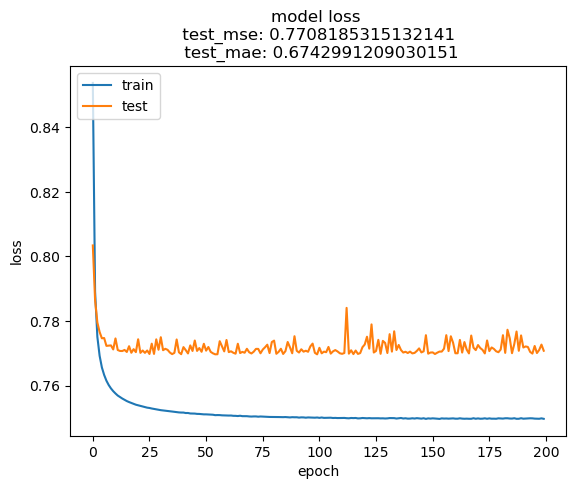

In [15]:
test_mse, test_mae = model.evaluate([df_val.userId, df_val.movieId], df_val.rating)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title(f"model loss \n test_mse: {test_mse} \n test_mae: {test_mae}")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.savefig(f'{model_name}.png')
plt.show()

In [483]:
user_id = 121
predicted_rating = model.predict([pd.Series([user_id]*len(dict_movies)), pd.Series(dict_movies.values())])
predicted_rating = pd.DataFrame(predicted_rating)
predicted_rating

304/304 [==============================] - 0s 475us/step


,0
0,4.044148
1,3.991875
2,1.205170
3,3.937061
4,2.624672
...,...
9719,4.193071
9720,4.154930
9721,4.039078
9722,4.168944


In [484]:
a = pd.DataFrame(dict_movies.keys(), columns=['movieId']).merge(df_movie, how="left", on="movieId")
a

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9720,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9721,193585,Flint (2017),Drama
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [485]:
result = pd.concat([a, predicted_rating], axis=1)
not_watched = result[~result.movieId.isin(movies_watched_by_user.movieId.values)]
top_10 = not_watched.sort_values(0, ascending=False)[['title', 'genres']].head(10)

top_10

,title,genres
3633,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
901,Aliens (1986),Action|Adventure|Horror|Sci-Fi
917,Ran (1985),Drama|War
1260,Starship Troopers (1997),Action|Sci-Fi
681,Singin' in the Rain (1952),Comedy|Musical|Romance
2019,Run Lola Run (Lola rennt) (1998),Action|Crime
1374,Fear and Loathing in Las Vegas (1998),Adventure|Comedy|Drama
8677,Guardians of the Galaxy 2 (2017),Action|Adventure|Sci-Fi
409,"Hudsucker Proxy, The (1994)",Comedy
994,Real Genius (1985),Comedy


In [439]:
not_watched[not_watched.title.apply(lambda x: 'Taken' in x)]

,movieId,title,genres,0
6729,59369,Taken (2008),Action|Crime|Drama|Thriller,4.999774
7973,96861,Taken 2 (2012),Action|Crime|Drama|Thriller,4.996769
8632,120635,Taken 3 (2015),Action|Crime|Thriller,4.995907


In [486]:
df[(df.userId == 586) & (df.title.apply(lambda x: 'Harry' in x))]

,userId,movieId,rating,timestamp,title,genres
90133,586,8368,5.0,1529899519,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX
90149,586,54001,4.5,1529899314,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX


In [487]:
not_watched[not_watched.title.apply(lambda x: 'Harry Potter' in x)]

,movieId,title,genres,0
3569,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,4.774970
4070,5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,1.467965
5156,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,4.979462
6045,40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX,2.561948
6505,54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX,4.490459
7061,69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX,4.955557
7448,81834,Harry Potter and the Deathly Hallows: Part 1 (...,Action|Adventure|Fantasy|IMAX,2.640421
7626,88125,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX,3.013352


In [488]:
df[(df.userId == 586) & (df.title.apply(lambda x: 'Thor' in x))]

,userId,movieId,rating,timestamp,title,genres
90226,586,122916,4.5,1529899181,Thor: Ragnarok (2017),Action|Adventure|Sci-Fi


In [489]:
not_watched[not_watched.title.apply(lambda x: 'Thor' in x)]

,movieId,title,genres,0
4397,6480,Thoroughly Modern Millie (1967),Comedy|Musical,4.297421
7571,86332,Thor (2011),Action|Adventure|Drama|Fantasy|IMAX,4.221145
8271,106072,Thor: The Dark World (2013),Action|Adventure|Fantasy|IMAX,2.982473
8676,122916,Thor: Ragnarok (2017),Action|Adventure|Sci-Fi,4.499731
9400,165639,While You Were Fighting: A Thor Mockumentary (...,Comedy|Fantasy|Sci-Fi,4.322000


## Weight & Bias Analysis

In [63]:
dict_weights = {}
for layer in model.layers:
    if layer.name in ["users_embeddings", "movies_embeddings"]:
        dict_weights[layer.name] = layer.weights

In [91]:
df_movies_embeddings = pd.DataFrame(dict_weights["movies_embeddings"][0].numpy())
df_movies_embeddings.columns = ["emb_" + str(col) for col in df_movies_embeddings.columns]
df_movies_embeddings.reset_index(inplace=True)
df_movies_embeddings.rename(columns={"index":"movieId"}, inplace=True)
df_movies_embeddings = df_movies_embeddings.merge(df_train[["movieId", "title"]].drop_duplicates(), how="left", on="movieId")

In [92]:
from sklearn.cluster import KMeans
km = KMeans(100)
km.fit(df_movies_embeddings[[col for col in df_movies_embeddings.columns if "emb" in col]])
clusters = km.predict(df_movies_embeddings[[col for col in df_movies_embeddings.columns if "emb" in col]])

In [93]:
df_movies_embeddings["cluster"] = clusters

In [94]:
df_movies_embeddings[df_movies_embeddings.cluster==49].title.unique()

array(['Clockers (1995)', 'Walk in the Clouds, A (1995)',
       'Bushwhacked (1995)', 'Secret of Roan Inish, The (1994)',
       'Timecop (1994)', 'Beverly Hills Cop III (1994)',
       'Demolition Man (1993)', 'Sliver (1993)', 'Solo (1996)',
       'Delta of Venus (1995)', 'Chain Reaction (1996)',
       'Crow: City of Angels, The (1996)', 'Basquiat (1996)',
       'Set It Off (1996)', 'Shadow Conspiracy (1997)',
       'Victor/Victoria (1982)', 'Body Parts (1991)',
       'Paradise Lost: The Child Murders at Robin Hood Hills (1996)',
       'Jaws 3-D (1983)', 'Fierce Creatures (1997)',
       'Absolute Power (1997)', 'Out to Sea (1997)', 'G.I. Jane (1997)',
       'Picture Perfect (1997)', 'Kull the Conqueror (1997)',
       'RocketMan (a.k.a. Rocket Man) (1997)', 'House of Yes, The (1997)',
       'Stranger in the House (1997)',
       'Friday the 13th Part IV: The Final Chapter (1984)',
       'Halloween II (1981)', 'Freaky Friday (1977)', 'Popeye (1980)',
       'Tall Tale (1995)

In [95]:
df_movies_embeddings[df_movies_embeddings.title == 'Star Wars: Episode IV - A New Hope (1977)'].cluster.values[0]

69

In [96]:
df_movies_embeddings[df_movies_embeddings.cluster==df_movies_embeddings[df_movies_embeddings.title == 'Harry Potter and the Chamber of Secrets (2002)'].cluster.values[0]].title.unique()

array(['Postman, The (Postino, Il) (1994)',
       "Antonia's Line (Antonia) (1995)",
       'Bridges of Madison County, The (1995)',
       'Up Close and Personal (1996)', 'French Kiss (1995)',
       'Tommy Boy (1995)', 'Forrest Gump (1994)', 'Pretty Woman (1990)',
       'Wallace & Gromit: The Best of Aardman Animation (1996)',
       'Tin Cup (1996)', 'All About Eve (1950)', 'Mary Poppins (1964)',
       'People vs. Larry Flynt, The (1996)',
       'Cinema Paradiso (Nuovo cinema Paradiso) (1989)',
       'Good Will Hunting (1997)', 'Shakespeare in Love (1998)',
       'For Your Eyes Only (1981)', 'Fatal Attraction (1987)',
       'Hook (1991)',
       'Girl on the Bridge, The (Fille sur le pont, La) (1999)',
       'Ghost World (2001)', 'Monsters, Inc. (2001)',
       "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)",
       'Black Hawk Down (2001)', 'Reign of Fire (2002)',
       'Harry Potter and the Chamber of Secrets (2002)',
     

In [120]:
df_movies_embeddings[df_movies_embeddings.cluster==df_movies_embeddings[df_movies_embeddings.title == 'Batman: The Dark Knight Returns, Part 1 (2012)'].cluster.values[0]].title.unique()

array(['Bed of Roses (1996)', 'Die Hard: With a Vengeance (1995)',
       'Just Cause (1995)', 'Outbreak (1995)', 'True Lies (1994)',
       'Last Action Hero (1993)', 'Three Musketeers, The (1993)',
       'Primal Fear (1996)',
       'Bloodsport 2 (a.k.a. Bloodsport II: The Next Kumite) (1996)',
       'Craft, The (1996)', 'Phenomenon (1996)',
       'Harold and Maude (1971)', 'Groundhog Day (1993)',
       'Indiana Jones and the Last Crusade (1989)',
       'American Werewolf in London, An (1981)',
       'Seven Years in Tibet (1997)', 'Life Less Ordinary, A (1997)',
       'Mulan (1998)', 'Rocky (1976)', 'Halloween (1978)',
       'Gremlins (1984)', 'Muppet Christmas Carol, The (1992)',
       'Rocketeer, The (1991)', 'Blade (1998)', 'Waterboy, The (1998)',
       'Karate Kid, Part II, The (1986)', 'Goldfinger (1964)',
       'From Russia with Love (1963)', 'Commitments, The (1991)',
       'Galaxy Quest (1999)', 'Spy Who Loved Me, The (1977)',
       'X-Men (2000)', 'Remember the 

In [119]:
df_movie[df_movie.title.apply(lambda x: 'Batman' in x)]

,movieId,title,genres
126,153,Batman Forever (1995),Action|Adventure|Comedy|Crime
509,592,Batman (1989),Action|Crime|Thriller
1060,1377,Batman Returns (1992),Action|Crime
1174,1562,Batman & Robin (1997),Action|Adventure|Fantasy|Thriller
2418,3213,Batman: Mask of the Phantasm (1993),Animation|Children
5463,26152,Batman (1966),Action|Adventure|Comedy
5620,27155,"Batman/Superman Movie, The (1998)",Action|Adventure|Animation|Children|Fantasy|Sc...
5631,27311,Batman Beyond: Return of the Joker (2000),Action|Animation|Crime|Sci-Fi|Thriller
5917,33794,Batman Begins (2005),Action|Crime|IMAX
6815,60979,Batman: Gotham Knight (2008),Action|Animation|Crime


In [89]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

In [91]:
# Let us get a user and see the top recommendations.
# user_id = ratings.userId.sample(1).iloc[0]
user_id = 252
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = df_movie[
    ~df_movie["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
#  mungkin salah di 2 paragraf di bawah vvvvv=============================================================================================================vvvvv
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
result = model.predict([df_train.userId, df_train.movieId]).flatten()
top_ratings_indices = result.argsort()[-15:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movies_rows = movies[movies["movieId"].isin(top_movies_user)]
for row in movies_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movies[movies["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

2521/2521 [==============================] - 3s 1ms/step


IndexError: list index out of range

In [100]:
tes = model.predict([df.userId, df.movieId])


   1/3152 [..............................] - ETA: 3:55

InvalidArgumentError: Graph execution error:

Detected at node 'model_3/movies_embeddings/embedding_lookup' defined at (most recent call last):
    File "C:\Users\Vincent\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Vincent\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Vincent\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Vincent\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Vincent\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Vincent\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Vincent\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Vincent\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Vincent\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Vincent\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Vincent\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Vincent\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\Vincent\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Vincent\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Vincent\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Vincent\AppData\Local\Temp\ipykernel_23916\128719125.py", line 1, in <module>
      tes = model.predict([df.userId, df.movieId])
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\engine\training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\engine\training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\engine\training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
      return self(x, training=False)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Vincent\anaconda3\lib\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model_3/movies_embeddings/embedding_lookup'
indices[14,0] = 46970 is not in [0, 9725)
	 [[{{node model_3/movies_embeddings/embedding_lookup}}]] [Op:__inference_predict_function_92164]

In [104]:
tes[4]

array([3.4973595], dtype=float32)

In [105]:
df_train[df_train.userId == 598]

,userId,movieId,rating,timestamp,title,genres
92899,598.0,584.0,3.0,1498525383,Multiplicity (1996),Comedy
94202,598.0,4619.0,3.0,1498521974,Elephant (2003),Drama
94201,598.0,4617.0,1.5,1498505002,Scary Movie 3 (2003),Comedy|Horror
94891,598.0,7963.0,2.5,1498532657,Robot & Frank (2012),Comedy|Drama|Sci-Fi
94489,598.0,5920.0,2.5,1498515064,Fantastic Four (2005),Action|Adventure|Sci-Fi
...,...,...,...,...,...,...
93232,598.0,1348.0,2.5,1519146702,City of Angels (1998),Drama|Fantasy|Romance
94939,598.0,8267.0,3.5,1498528415,12 Years a Slave (2013),Drama
93458,598.0,1957.0,2.5,1498513853,Lost & Found (1999),Comedy|Romance
92766,598.0,311.0,2.5,1498517384,"Crow, The (1994)",Action|Crime|Fantasy|Thriller
